# Idea:  
We want to evaluate the model on a true numerical integration grid but get the amount of count inside the mask which is define in reco coordinates.

Therefore we use the energy dispersion to compute which true energy bin contributes how much into the reco bins where mask==True. The bins do not have to be alligned if the kernel is properly calculated.

For the PSF we convolve the mask with the PSF Kernel. Here we need the same pixelsize of the mask and the true geometry on which the model is evaluated. So in a first step the mask is interpolated on the true geometry.

In [1]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker
from gammapy.irf import EDispKernel, EDispMap, EnergyDispersion2D, EDispKernelMap, PSFMap, PSF3D, PSFKernel
from gammapy.makers.utils import make_psf_map
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)
from gammapy.estimators import ImageProfileEstimator


1.0


In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [3]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.geomspace(0.5,100,30) # a fine binning in true energy
energy_axis = MapAxis.from_edges(
    ebins[::2], unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

## First the energy response
Check the acceptance method without any psf

In [30]:
%%time
maker = MapDatasetMaker(selection=["counts", 'exposure','edisp'])

reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)
dataset = maker.run(reference, obs1)

reference_4kernel = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
dataset_kernel = maker.run(reference_4kernel, obs1)

CPU times: user 1.48 s, sys: 68 ms, total: 1.54 s
Wall time: 2.52 s


In [31]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )

model_gauss.spectral_model.amplitude.value /= 10. # 10 times weaker signal than the Crab

dataset.exposure.quantity = 1. * dataset.exposure.unit # for comparison neglect exposure here
dataset.models=[model_gauss]

### Define a mask which cuts both in energy and space

In [32]:
# define a mask safe which cuts from the model in space and energy
mask_safe = dataset.counts.copy()
mask_safe.data = True
coords_ms = mask_safe.geom.get_coord(sparse=True)
sep = coords_ms.skycoord.separation(obs_pos)
mask_safe.data *= sep < .6 * u.deg
e_mask=mask_safe.geom.energy_mask(1*u.TeV, 30*u.TeV)
mask_safe.data *= e_mask
dataset.mask_safe = mask_safe

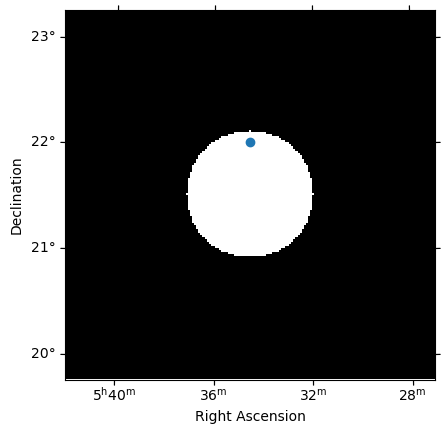

In [33]:
dataset.mask_safe.sum_over_axes().plot()
ax=plt.gca()
plt.scatter(model_gauss.position.icrs.ra, model_gauss.position.icrs.dec, transform=ax.get_transform('world'))

In [34]:
# define geometry with different binning compared to mask_safe
ebins_model = np.geomspace(0.5,100,45) 
energy_axis_model = MapAxis.from_edges(
    ebins_model, unit="TeV", name="energy_true", interp="log"  
)
geom_model = WcsGeom.create(
    skydir=crab_pos,
    binsz=0.01,
    width=(0.5, 0.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis_model],
)

e_reco = mask_safe.geom.axes['energy']
e_true = geom_model.axes["energy_true"]
fake_reco = e_true.copy(name='energy')
fake_true = e_reco.copy(name='energy_true')
    
geom_model_mask = geom_model.to_image().to_cube([e_reco])
coords_model = geom_model_mask.get_coord()  # or take the coords directly if coords are passed
mask_model = Map.from_geom(geom=geom_model_mask.as_energy_true, 
                           data=mask_safe.interp_by_coord(coords_model))

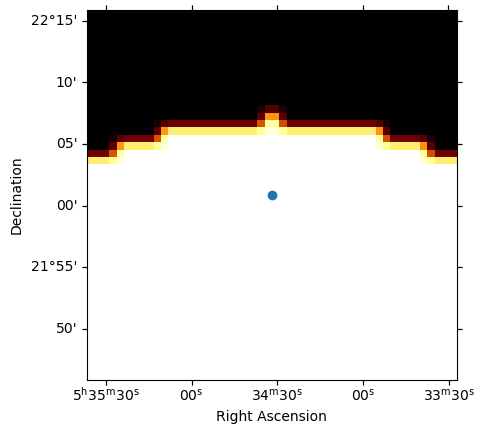

In [35]:
# look at the interpolated mask
# pixels on the edge of mask_safe will get fractional values
mask_model.sum_over_axes().plot()
ax=plt.gca()
plt.scatter(model_gauss.position.icrs.ra, model_gauss.position.icrs.dec, transform=ax.get_transform('world'))

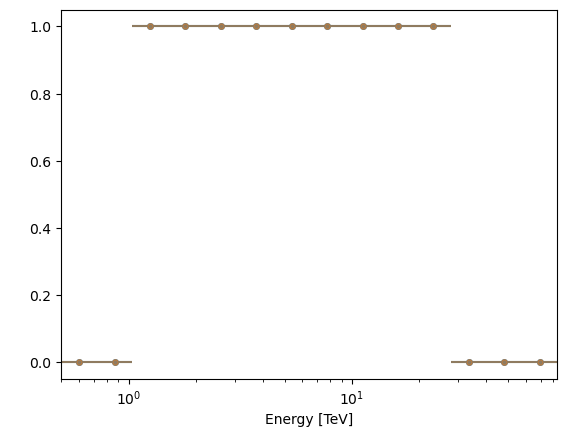

In [36]:
# the same happens in energy if we choose different energy binning
# but the edisp will also handle this so we stick to the same energy binning for now
mask_model.get_spectrum(region=crab_pos).plot()
mask_safe.get_spectrum(region=crab_pos).plot(alpha=0.5)
plt.yscale("linear")

### Try to recover the npred inside the mask

In [37]:
def make_acceptance(geom, mask, edisp, model_pos, pointing=None):
   ## get the energy axes and copy them for the transposed EDispKernel
    e_reco = mask.geom.axes['energy']
    e_true = geom.axes["energy_true"]
    fake_reco = e_true.copy(name='energy')
    fake_true = e_reco.copy(name='energy_true')
    ## interpolate the mask to the integration geometry on which the back folding takes place
    geom_model_mask = geom.to_image().to_cube([e_reco])
    coords = geom_model_mask.get_coord()  
    # the mask_safe in model geometry but with axis energy label energy_true
    mask_model = Map.from_geom(geom=geom_model_mask.as_energy_true, 
                               data=mask.interp_by_coord(coords))
    
    ## create edisp 
    # because we want to convolve a reco map we do a trick and create a transposed EdispKernel
    if isinstance(edisp, EDispMap):
        # we need to adapt to possibly different e_true axis
        # so we we interpolate to different e_true before generating the kernel
        migra = e_reco.edges[:,None]/e_true.center
        coords = {
            "skycoord": model_pos,
            "energy_true": e_true.center,
            "migra": migra,
        }
        values = edisp.edisp_map.integral(axis_name="migra", coords=coords)

        axis = 0 # diff alon the migra (reco) axis which is at dim0 for coord[skycoord] beeing a single position
        data = np.clip(np.diff(values.to_value(''), axis=axis), 0, np.inf)
        edisp_kernelT = EDispKernel(axes=[fake_true, fake_reco], data = data)
        
    if isinstance(edisp, EDispKernelMap):
        # the reco energy axis should match, but this should be the case if the mask is in reco coords of the dataset
        # different axis probably need new normalizationand this is not tested
        assert e_reco == edisp.edisp_map.geom.axes["energy"]
        coords = {
            "skycoord": model_gauss.position,
            "energy_true": e_true.center,
            "energy": e_reco.center[:,None],
        }
        data = edisp.edisp_map.interp_by_coord(coords)  # interpolate to new e_true axis
        edisp_kernelT = EDispKernel(axes=[fake_true, fake_reco], data = data)
     
    if isinstance(edisp, EnergyDispersion2D):
        offset = model_pos.separation(pointing)
        edisp_kernel = edisp.to_edisp_kernel(offset, 
                                             energy_true=e_true.edges , 
                                             energy=e_reco.edges)
        
        edisp_kernelT = EDispKernel(axes=[fake_true, fake_reco], data = edisp_kernel.data.T)
  
        

    acceptance=mask_model.apply_edisp(edisp_kernelT) 
    return acceptance

In [38]:
%%time
acc_emap=make_acceptance(geom_model, mask_safe, dataset.edisp, model_gauss.position, obs_pos)
acc_eobs=make_acceptance(geom_model, mask_safe, obs1.edisp, model_gauss.position, obs_pos)
acc_eker=make_acceptance(geom_model, mask_safe, dataset_kernel.edisp, model_gauss.position, obs_pos)

CPU times: user 121 ms, sys: 830 µs, total: 122 ms
Wall time: 214 ms


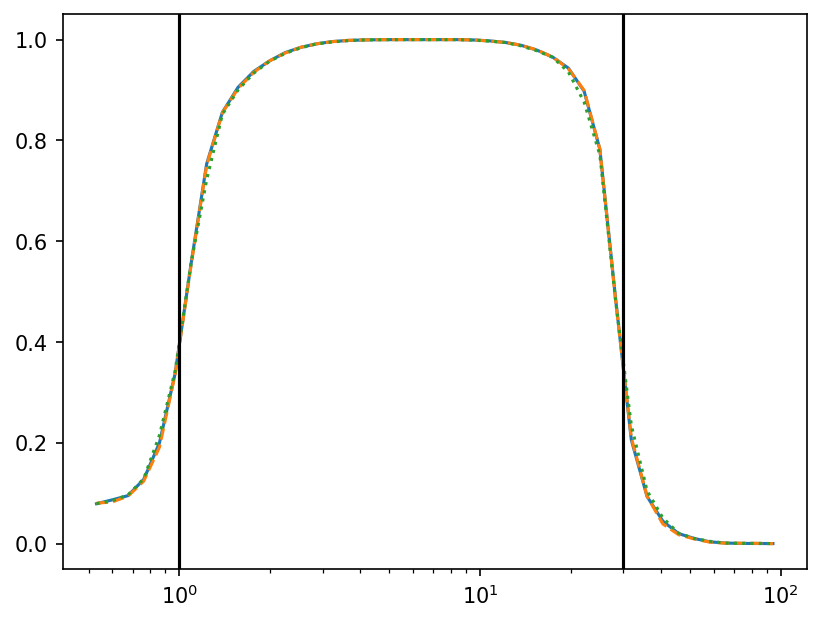

In [39]:
## compare the acceptance maps from EDispMap and EnergyDispersion2D
plt.figure(dpi=150)
plt.semilogx(e_true.center,acc_emap.get_spectrum(crab_pos).data.squeeze(), label="EDispMap")
plt.semilogx(e_true.center,acc_eobs.get_spectrum(crab_pos).data.squeeze(), label="EDisp2D", ls="--")
plt.semilogx(e_true.center,acc_eker.get_spectrum(crab_pos).data.squeeze(), label="EDKernel", ls=":")
plt.axvline(1, color="k")  # the energy bound in reco energy
plt.axvline(30, color="k")

In [40]:
## compare the npred of the MapEvaluator and the acceptance method
npred_ev = (dataset.npred_signal().data*dataset.mask_safe.data).sum()
print("npred using MapEvaluator: \t {:.3e}".format(npred_ev))

model_int = model_gauss.integrate_geom(geom_model)
npred_emap = (model_int.data * acc_emap.data).sum()*1e4  # from exposure cm^2 --> m^2
npred_eobs = (model_int.data * acc_eobs.data).sum()*1e4
npred_eker = (model_int.data * acc_eker.data).sum()*1e4

print("npred with EDispMap: \t {:.3e} (ratio {:.2%})".format(npred_emap, npred_emap/npred_ev-1))
print("npred with EDisp2D: \t {:.3e} (ratio {:.2%})".format(npred_eobs, npred_eobs/npred_ev-1))
print("npred with EDKernel: \t {:.3e} (ratio {:.2%})".format(npred_eker, npred_eker/npred_ev-1))

eval_int=dataset.evaluators['crab_model_gauss'].compute_flux().data.sum()
print(f"ratio of raw model integration due to different geometries: {model_int.data.sum()/eval_int-1:.4%}")

npred using MapEvaluator: 	 2.694e-08
npred with EDispMap: 	 2.703e-08 (ratio 0.34%)
npred with EDisp2D: 	 2.691e-08 (ratio -0.10%)
npred with EDKernel: 	 2.698e-08 (ratio 0.16%)
ratio of raw model integration due to different geometries: 0.0010%


In [73]:
## check the precision for different model evaluation grids
n_ebins=np.arange(15,64,3)
ratios=[]
for n in n_ebins:
    ebins_model = np.geomspace(0.5,100,n) 
    energy_axis_model = MapAxis.from_edges(
        ebins_model, unit="TeV", name="energy_true", interp="log"  
    )
    geom_model = WcsGeom.create(
        skydir=crab_pos,
        binsz=0.02,
        width=(0.5, 0.5),
        frame="icrs",
        proj="CAR",
        axes=[energy_axis_model],
    )
    model_int = model_gauss.integrate_geom(geom_model)
    
    acc_emap=make_acceptance(geom_model, mask_safe, dataset.edisp, model_gauss.position, obs_pos)
    acc_eobs=make_acceptance(geom_model, mask_safe, obs1.edisp, model_gauss.position, obs_pos)
    acc_eker=make_acceptance(geom_model, mask_safe, dataset_kernel.edisp, model_gauss.position, obs_pos)
    
    npred_emap = (model_int.data * acc_emap.data).sum()*1e4  # from exposure cm^2 --> m^2
    npred_eobs = (model_int.data * acc_eobs.data).sum()*1e4
    npred_eker = (model_int.data * acc_eker.data).sum()*1e4
    
    ratios.append([npred_emap/npred_ev, npred_eobs/npred_ev, npred_eker/npred_ev])
    
ratios = np.array(ratios)

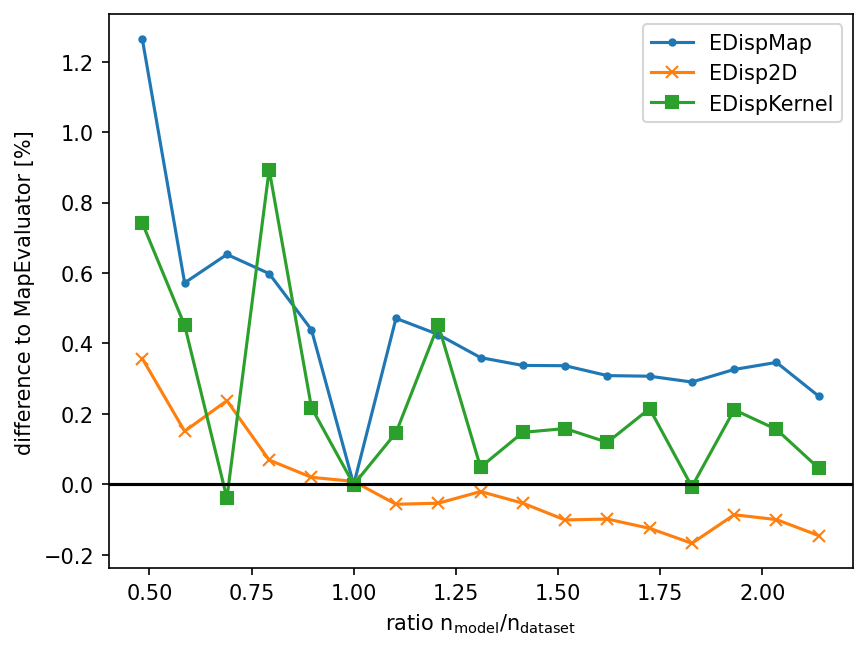

In [83]:
plt.figure(dpi=150)
x=(n_ebins-1)/len(energy_axis_true.center)
plt.plot(x, (ratios[:,0]-1)*100, label="EDispMap", marker= ".")
plt.plot(x, (ratios[:,1]-1)*100, label="EDisp2D", marker= "x")
plt.plot(x, (ratios[:,2]-1)*100, label="EDispKernel", marker= "s")

plt.legend()
plt.xlabel("ratio n$_\mathrm{model}$/n$_\mathrm{dataset}$")
plt.ylabel("difference to MapEvaluator [%]")
plt.axhline(0, color="k")

**Conclusion Energy Response**

In general the method works well also if the energy bin of the mask, the MapEvaluator and the integration grid are very different. The deviations are below 0.5% in most cases. The differences also depend on the class of Energy Dispersion used for the acceptance matrix. If the energy axes are the same we recover the same number of prediced counts inside the mask as the MapEvaluator does. That seems to be the case for all classes.

## closer look at the psf values

The problem inverstigated here is that a minor spatial offset in the geometry leads to very different PSF kernel values. While the PSF looks similar this influences the exact number of predicted counts inside the mask if the source is close to the mask.

In [11]:
psf= obs1.psf
pointing=obs_pos
model_pos = model_gauss.position
geom_psf = mask_safe.geom.to_image().cutout(model_pos, mask_safe.geom.pixel_scales*3)
geom_psf = geom_psf.to_cube([psf.axes['rad'], geom_model.axes['energy_true']])
psfmap = make_psf_map(psf, pointing, geom_psf)
# now get the kernel at the model position
psf_kernel = psfmap.get_psf_kernel(geom_model, position=model_pos)

In [12]:
pos_fake = model_pos.directional_offset_by(-100*u.deg, 0.015*u.deg)
psf_kernel2 = psfmap.get_psf_kernel(geom_model, position=pos_fake)

print(pos_fake.separation(pointing).deg)
print(model_pos.separation(pointing).deg)

0.5118174843714088
0.5006313141641109


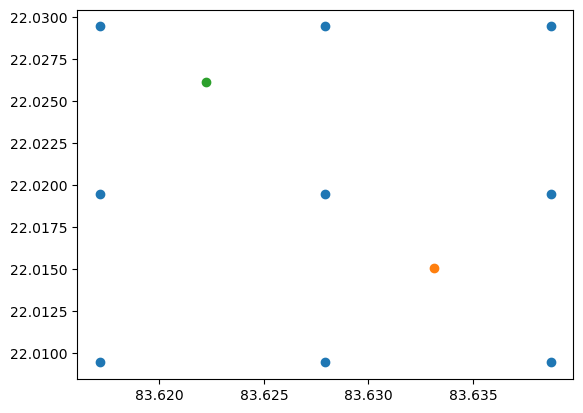

In [13]:
coords_psf=geom_psf.get_coord(sparse=True)
plt.plot(coords_psf['lon'].flatten(), coords_psf['lat'].flatten(), 'o')
plt.plot(model_pos.icrs.ra.deg, model_pos.icrs.dec.deg, 'o')
plt.plot(pos_fake.icrs.ra.deg, pos_fake.icrs.dec.deg, 'o')

In [14]:
np.all(np.isclose(psf_kernel.data, psf_kernel2.data, rtol=1e-1, atol=0),axis=(1,2))

array([False, False,  True,  True,  True, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False,  True,  True,  True, False,  True, False, False, False,
       False, False, False])

(array([1.76000e+02, 7.41800e+03, 6.81865e+05, 2.26000e+02, 5.60000e+01,
        3.20000e+01, 2.50000e+01, 1.70000e+01, 9.00000e+00, 1.20000e+01,
        4.00000e+00, 9.00000e+00, 4.00000e+00, 8.00000e+00, 0.00000e+00,
        5.00000e+00, 0.00000e+00, 4.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-2.66414169e-05, -1.38414804e-05, -1.04154381e-06,  1.17583927e-05,
         2.45583293e-05,  3.73582659e-05,  5.01582024e-05,  6.29581390e-05,
         7.57580755e-05,  8.85580121e-05,  1.01357949e-04,  1.14157885e-04,
         1.26957822e-04,  1.39757758e-04,  1.52557695e-04,  1.65357631e-04,
         1.78157568e-04,  1.90957505e-04,  2.03757441e-04,  2.16557378e-04,
         2.29357314e-04]),
 <BarContainer object of 20 artists>)

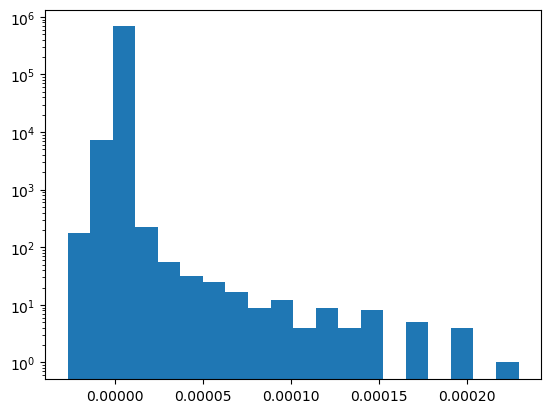

In [15]:
diff = (psf_kernel.data - psf_kernel2.data)#/psf_kernel.data
# diff[np.abs(diff)>1]=0
plt.hist(np.nan_to_num(diff.flatten()), bins=20, log=True)

### however the psfs look very similar

In [16]:
dataset.npred()
ev=dataset.evaluators['crab_model_gauss']

In [17]:
ev.psf.psf_kernel_map.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [18]:
psf_kernel.psf_kernel_map.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [19]:
psf_kernel2.psf_kernel_map.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

## recreate the dataset with PSF (no EDisp)

In [193]:
def make_acceptance(geom, mask, psf, model_pos, pointing=None, max_radius=None,containment=0.999, factor=4):
    ## get the energy axes and copy them for the transposed EDispKernel
    e_reco = mask.geom.axes['energy']
    e_true = geom.axes["energy_true"]
    fake_reco = e_true.copy(name='energy')
    fake_true = e_reco.copy(name='energy_true')
    ## interpolate the mask to the integration geometry on which the back folding takes place
    geom_model_mask = geom.to_image().to_cube([e_reco])
    
    ## the PSF needs a larger map for evaluation
    if psf is not None:
        width_geom = geom.width.max()
        if max_radius is None:
            kwargs = {
                "fraction": containment,
                "energy_true": e_true.center,
            }
            if isinstance(psf, PSFMap):
                kwargs['position'] = model_pos
            elif isinstance(psf, PSF3D):
                kwargs['offset'] = model_pos.separation(pointing)
            radii = psf.containment_radius(**kwargs)
            max_radius = np.max(radii)
        print(width_geom/2 + max_radius)
        geom_model_mask=geom_model_mask.to_odd_npix(max_radius + width_geom/2)
    
    coords = geom_model_mask.get_coord()  
    # the mask_safe in model geometry but with axis energy label energy_true
    mask_model = Map.from_geom(geom=geom_model_mask.as_energy_true, 
                               data=mask.interp_by_coord(coords, fill_value=0.0))
#     return mask_model,1
  
   ## create the psf
    if isinstance(psf, PSFMap):
        # need to interpolate to the e_true of the geom
        model_pos = psf._get_nearest_valid_position(model_pos)

        geom_psf = geom.to_odd_npix(max_radius=max_radius)
        geom_upsampled = geom_psf.upsample(factor=factor)
        coords = geom_upsampled.get_coord(sparse=True)
        rad = coords.skycoord.separation(geom.center_skydir)

        coords = {
        "energy_true": coords["energy_true"],
        "rad": rad,
        "skycoord": model_pos,
        }

        data = psf.psf_map.interp_by_coord(
        coords=coords,
        method="linear",
        )

        kernel_map = Map.from_geom(geom=geom_upsampled, data=np.clip(data, 0, np.inf))
        kernel_map = kernel_map.downsample(factor, preserve_counts=True)
        psf_kernel = PSFKernel(kernel_map, normalize=True)
    if isinstance(psf, PSF3D):
        # first a PSFMap with 3x3 pixels around the model_position
        geom_psf = mask.geom.to_image().cutout(model_pos, mask.geom.pixel_scales*3)
        geom_psf = geom_psf.to_cube([psf.axes['rad'], geom.axes['energy_true']])
        psfmap = make_psf_map(psf, pointing, geom_psf)
        # now get the kernel at the model position
        psf_kernel = psfmap.get_psf_kernel(geom, position=model_pos)

    acceptance=mask_model.convolve(psf_kernel)
    acceptance=acceptance.cutout(geom.center_skydir, width_geom)
    return acceptance, psf_kernel # but edisp does ereco --> etrue and psf is in etrue

In [6]:
%%time
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
assert np.all(energy_axis.edges == energy_axis_true.edges)  # use the same energy binning now
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)
maker = MapDatasetMaker(selection=["counts", 'exposure','psf'])

reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)
dataset = maker.run(reference, obs1)

dataset.exposure.quantity = 1. * dataset.exposure.unit # for comparison neglect exposure here

model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )

model_gauss.spectral_model.amplitude.value /= 10. # 10 times weaker signal than the Crab
dataset.models=[model_gauss]

CPU times: user 541 ms, sys: 50 ms, total: 591 ms
Wall time: 600 ms


In [200]:
# the integration geometry with same energy binning but different pixel sizes and different center position
geom_model = WcsGeom.create(
    skydir=crab_pos,
    binsz=0.01,
    width=(0.5, 0.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis_true],
)

# redefine the mask with the correct energy_bins
# define a mask safe which cuts from the model in space and energy
mask_safe = dataset.counts.copy()
mask_safe.data = True
coords_ms = mask_safe.geom.get_coord(sparse=True)
sep = coords_ms.skycoord.separation(obs_pos)
mask_safe.data *= sep < .4 * u.deg
e_mask=mask_safe.geom.energy_mask(0.8*u.TeV, 30*u.TeV)
mask_safe.data *= e_mask
dataset.mask_safe = mask_safe

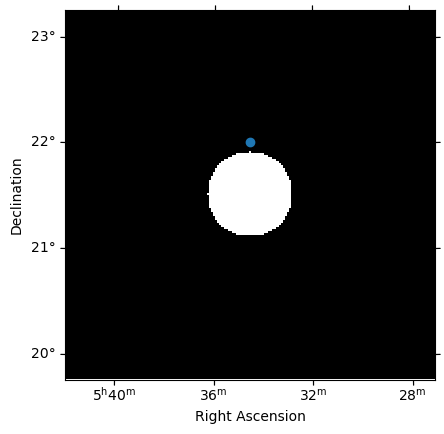

In [201]:
dataset.mask_safe.sum_over_axes().plot()
ax=plt.gca()
plt.scatter(model_gauss.position.icrs.ra, model_gauss.position.icrs.dec, transform=ax.get_transform('world'))

### For geom with offset and different pixel size

In [202]:
%%time
acc_pmap, kernel_pmap = make_acceptance(geom_model, mask_safe, dataset.psf, model_gauss.position, obs_pos)
acc_pobs, kernel_pobs = make_acceptance(geom_model, mask_safe, obs1.psf, model_gauss.position, obs_pos)

0.90225 deg
0.9124906480312345 deg
CPU times: user 8.47 s, sys: 2.53 s, total: 11 s
Wall time: 11 s


In [203]:
## compare the npred of the MapEvaluator and the acceptance method
npred_ev = (dataset.npred_signal().data*dataset.mask_safe.data).sum()
print("npred using MapEvaluator: \t {:.3e}".format(npred_ev))

model_int = model_gauss.integrate_geom(geom_model)
npred_pmap = (model_int.data * acc_pmap.data).sum()*1e4  # from exposure cm^2 --> m^2
npred_pobs = (model_int.data * acc_pobs.data).sum()*1e4

print("npred with PSFMap: \t {:.5e} (ratio {:.4%})".format(npred_pmap, npred_pmap/npred_ev-1))
print("npred with PSF3D: \t {:.5e} (ratio {:.4%})".format(npred_pobs, npred_pobs/npred_ev-1))

eval_int=dataset.evaluators['crab_model_gauss'].compute_flux().data.sum()
print(f"ratio of raw model integration due to different geometries: {model_int.data.sum()/eval_int-1:.4%}")

npred using MapEvaluator: 	 2.951e-09
npred with PSFMap: 	 3.16413e-09 (ratio 7.2382%)
npred with PSF3D: 	 3.16243e-09 (ratio 7.1802%)
ratio of raw model integration due to different geometries: 0.0009%


In [11]:
method='mean'  # 'sum'
theta_sq=np.linspace(0,0.04,50)
theta=Angle(np.sqrt(theta_sq), unit='deg')
# print(np.diff(theta.deg))
profiles=[]
for kernel in [kernel_pmap, kernel_pobs, dataset.evaluators["crab_model_gauss"].psf]:
    pos = kernel.psf_kernel_map.geom.center_skydir
    p = ImageProfileEstimator(axis='radial', method=method, center=pos, x_edges=theta)

    profile = p.run(kernel.psf_kernel_map)

    # in case method = mean
    if method == 'mean':
        geom=kernel.psf_kernel_map.geom.to_image()
        idx_crab=geom.coord_to_idx(pos)
        solid_angle_geom=geom.solid_angle()[idx_crab]
        solid_angle_bin = np.pi*np.diff(theta_sq)*u.deg**2
        nebins=kernel.psf_kernel_map.data.shape[0] # 1 ## scipy mean devides by the number of image pixels times the number of ebins. If 2d maps are used nebin=1
        bin_per_sa = nebins*(solid_angle_bin/solid_angle_geom).to('')
        profile.table['profile']*=bin_per_sa.value
    
    profiles.append(profile)   

/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)


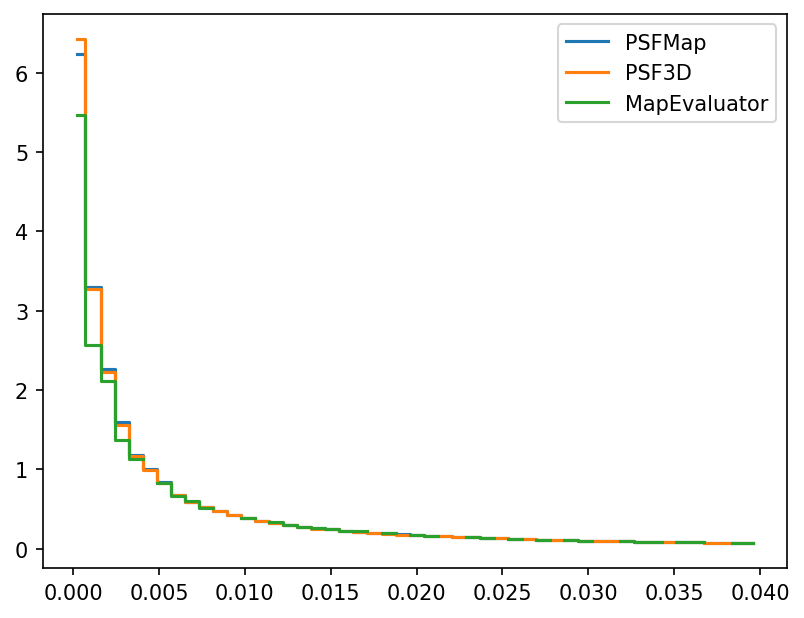

In [12]:
plt.figure(dpi=150)
labels=["PSFMap", "PSF3D", "MapEvaluator"]
for i,p in enumerate(profiles):
    plt.plot(p.table['x_ref']**2, p.table['profile'], ds='steps-mid', label=labels[i])
    
plt.legend()

### For geom alligned and same pixel size

In [52]:
width_mapevaluator = dataset.evaluators["crab_model_gauss"].exposure.geom.width.max()
width_mapevaluator

<Quantity 1.74 deg>

In [53]:
%%time
geom_model2 = dataset.exposure.geom.cutout(crab_pos, width_mapevaluator, odd_npix=True)#.upsample(2)

acc_pmap2, kernel_pmap2 = make_acceptance(geom_model2, mask_safe, dataset.psf, model_gauss.position, obs_pos)
acc_pobs2, kernel_pobs2 = make_acceptance(geom_model2, mask_safe, obs1.psf, model_gauss.position, obs_pos)

CPU times: user 1.79 s, sys: 75.5 ms, total: 1.87 s
Wall time: 1.87 s


In [54]:
## compare the npred of the MapEvaluator and the acceptance method
npred_ev = (dataset.npred_signal().data*dataset.mask_safe.data).sum()
print("npred using MapEvaluator: \t {:.5e}".format(npred_ev))

model_int2 = model_gauss.integrate_geom(geom_model2)
npred_pmap2 = (model_int2.data * acc_pmap2.data).sum()*1e4  # from exposure cm^2 --> m^2
npred_pobs2 = (model_int2.data * acc_pobs2.data).sum()*1e4

print("npred with PSFMap: \t {:.5e} (ratio {:.5%})".format(npred_pmap2, npred_pmap2/npred_ev-1))
print("npred with PSF3D: \t {:.5e} (ratio {:.5%})".format(npred_pobs2, npred_pobs2/npred_ev-1))

eval_int=dataset.evaluators['crab_model_gauss'].compute_flux().data.sum()
print(f"ratio of raw model integration due to different geometries: {model_int2.data.sum()/eval_int-1:.4%}")

npred using MapEvaluator: 	 2.75416e-08
npred with PSFMap: 	 2.77932e-08 (ratio 0.91350%)
npred with PSF3D: 	 2.75861e-08 (ratio 0.16160%)
ratio of raw model integration due to different geometries: 0.0000%


In [15]:
method='mean'  # 'sum'
theta_sq=np.linspace(0,0.04,25)
theta=Angle(np.sqrt(theta_sq), unit='deg')
# print(np.diff(theta.deg))
profiles2=[]
for kernel in [kernel_pmap2, kernel_pobs2, dataset.evaluators["crab_model_gauss"].psf]:
    pos = kernel.psf_kernel_map.geom.center_skydir
    p = ImageProfileEstimator(axis='radial', method=method, center=pos, x_edges=theta)

    profile = p.run(kernel.psf_kernel_map)

    # in case method = mean
    if method == 'mean':
        geom=kernel.psf_kernel_map.geom.to_image()
        idx_crab=geom.coord_to_idx(pos)
        solid_angle_geom=geom.solid_angle()[idx_crab]
        solid_angle_bin = np.pi*np.diff(theta_sq)*u.deg**2
        nebins=kernel.psf_kernel_map.data.shape[0] # 1 ## scipy mean devides by the number of image pixels times the number of ebins. If 2d maps are used nebin=1
        bin_per_sa = nebins*(solid_angle_bin/solid_angle_geom).to('')
        profile.table['profile']*=bin_per_sa.value
    
    profiles2.append(profile)   

/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)
/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:684: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)


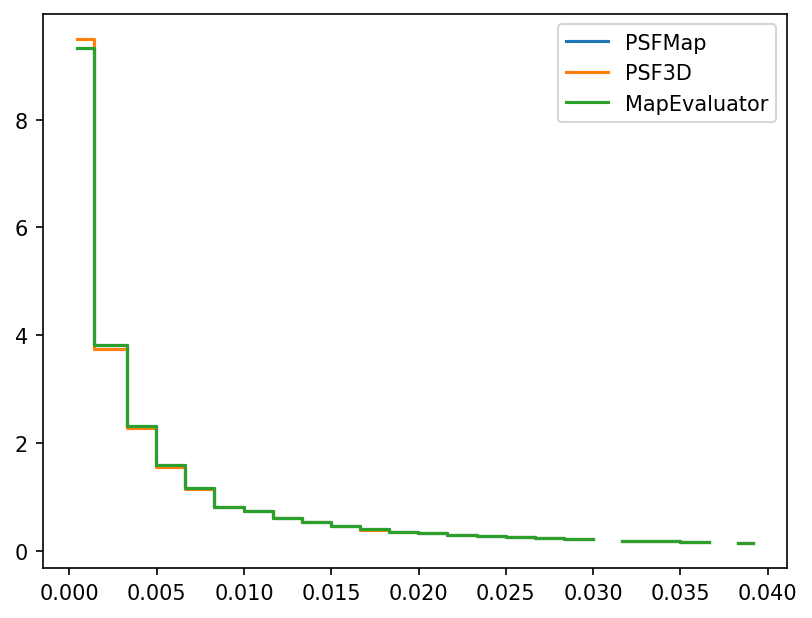

In [16]:
plt.figure(dpi=150)
labels=["PSFMap", "PSF3D", "MapEvaluator"]
for i,p in enumerate(profiles2):
    plt.plot(p.table['x_ref']**2, p.table['profile'], ds='steps-mid', label=labels[i])
    
plt.legend()

**Conclusion PSF response**

The PSF shapes differ a little bit if the integration geometry is upsampled compared to the geometry of the MapEvaluator. The offset does not play any role here.  

~~The ratio of npred however is always about 5% lower compared to the MapEvaluator independent of the offset or pixel scale. This means that the handling of different offset and pixel scales might not be the problem but rather a general problem with the method?~~

This was the case if the size of the model_geom was small compared to the size of the PSFKernel and if the window of the model_geom cuts away parts where the mask is True.  
The fix is to extend the model_geom by the PSF radius and interpolate the mask on that geom. This geom can then be used for the convolution and afterwards be cutout to the initial geometry.  
With that we get a difference of around 0%-1% if the mask does not cut fully into the source. In that case the difference can be up to 10%. This needs to be investigated.

## test the function

In [10]:
def make_acceptance(mask_safe, edisp, psf, model_pos, pointing, geom_model):
    """Compute the acceptance cube with dimensions of `geom_model`. The cube can be multiplied to the model which is integrated on `geom_model` and the sum over the result will give the total number of model counts inside the `mask_safe` which is in reco coordinates.

        Parameters
        ----------
        mask_safe : `~gammapy.maps.WcsNDMap`
            analysis mask in reco coordinates    
        edisp : `~gammapy.irf.EnergyDispersion2D`
            Energy Dispersion from the observaton
        psf : `~gammapy.irf.PSF3D`
            Point spread function from the observaton
        model_pos : `~astropy.coordinates.SkyCoord`
            Ceter position of the model. In the future this can be extracted from the geom_model
        pointing : `~astropy.coordinates.SkyCoord`
            Pointing position of the observation. Should be a single coordinates.
        geom_model : `~gammapy.maps.WcsGeom`
            Geometry with coordinates on which the model will be evaluated. Needs true energy axis and skycoord.

        Returns
        -------
        acceptance : `~gammapy.maps.WcsNDMap`
            the acceptance map for the unbinned evaluator.
    """
#     It will be model specific. 
#     offset = offset of model_pos and pointing (same as is used for binned)
#     geom_model = geom on which the model is evaluated, maybe we want to pass coords instead
#     a new mask needs to be interpolated from the mask safe on the geom
    offset = model_pos.separation(pointing)
    ## get the new mask_safe based on the geometry on which the model is evaluated
    geom_model_mask = geom_model.to_image().to_cube([mask_safe.geom.axes['energy']])
    coords_model = geom_model_mask.get_coord()  # or take the coords directly if coords are passed
    # the mask_safe in model geometry
    mask_model = Map.from_geom(geom=geom_model_mask.as_energy_true, 
                               data=mask_safe.interp_by_coord(coords_model))
    
    ## create edisp 
    # because we want to convolve a reco map we do a trick and create a transposed EdispKernel
    edisp_kernel = edisp.to_edisp_kernel(offset, 
                                         energy_true=geom_model.axes['energy_true'].edges , 
                                         energy=mask_safe.geom.axes['energy'].edges)
    # change the axes
    ax_reco = geom_model.axes['energy_true'].copy()
    ax_true = mask_safe.geom.axes['energy'].copy()
    ax_reco._name="energy"
    ax_true._name='energy_true'
    edisp_kernelT = EDispKernel(axes=[ax_true, ax_reco], data = edisp_kernel.data.T)
    
    ## create the psf
    # first a PSFMap with 3x3 pixels around the model_position
    geom_psf = mask_safe.geom.to_image().cutout(model_pos, mask_safe.geom.pixel_scales*3)
    geom_psf = geom_psf.to_cube([psf.axes['rad'], geom_model.axes['energy_true']])
    psfmap = make_psf_map(psf, pointing, geom_psf)
    # now get the kernel at the model position
    psf_kernel = psfmap.get_psf_kernel(geom_model, position=model_pos)

    acceptance=mask_model.apply_edisp(edisp_kernelT)  # order of edisp and psf doesn't matter much
    return acceptance.convolve(psf_kernel) # but edisp does ereco --> etrue and psf is in etrue

In [12]:
# %%time
# When using the mask_safe.geom for the model evaluation
acceptance=make_acceptance(mask_safe, obs1.edisp, obs1.psf, model_gauss.position, obs_pos, mask_safe.geom.as_energy_true)

In [13]:
# the acceptance is the interpolated mask_safe smoothed with the irfs
acceptance.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [86]:
# get both the total npred in true coordinates and the amount that falls into the reco mask_safe
npred_true=model_gauss.integrate_geom(geom_model)
npred_sum = np.sum(npred_true.quantity.to_value("s-1 m-2") * acceptance.data)
print(npred_sum)
print(npred_true.quantity.to_value("s-1 m-2").sum())

2.3977646581555372e-08
5.733697816914333e-08


In [87]:
# compare to the total npred in reco coordinates and the amount that falls into the reco mask_safe
npred_ds = dataset.npred()  # also contains background
npred_ds.data = 0.
npred_source=dataset.evaluators['crab_model_gauss'].compute_npred()
npred_ds.stack(npred_source) # we need the full map geometry to apply the safe mask
print(npred_ds.data[mask_safe.data].sum())
print(npred_ds.data.sum())

2.397609347982785e-08
5.702710049135778e-08


In [88]:
ev=dataset.evaluators['crab_model_gauss']
ev.apply_exposure(ev.compute_flux_psf_convolved()).data.sum()

5.7336977544395905e-08

In [106]:
# npred_true=model_gauss.integrate_geom(ev.exposure.geom)
# npred_sum = np.sum(npred_true.quantity.to_value("s-1 m-2") * acceptance.data)
# print(npred_sum)
# print(npred_true.quantity.to_value("s-1 m-2").sum())

In [89]:
ratio_binned=[]
ratio_unbinned=[]
ratio_both=[]
alphas=np.linspace(0.5,3.5,10)
for alpha in alphas:
    model_gauss.spectral_model.alpha.value = alpha
    
#     npred_true=model_gauss.integrate_geom(mask_safe.geom.as_energy_true)
    npred_true=model_gauss.integrate_geom(geom_model)
    npred_sum = np.sum(npred_true.quantity.to_value("s-1 m-2") * acceptance.data)
    usm=npred_sum
    us=npred_true.quantity.to_value("s-1 m-2").sum()
    ratio_unbinned.append(usm/us)
    
    npred_ds = dataset.npred()  # also contains background
    npred_ds.data = 0.
    npred_source=dataset.evaluators['crab_model_gauss'].compute_npred()
    npred_ds.stack(npred_source) # we need the full map geometry to apply the safe mask
    sbm=npred_ds.data[mask_safe.data].sum()
    sb=npred_ds.data.sum()
    ratio_binned.append(sbm/sb)
    
    ratio_both.append(usm/sbm)

Text(0.5, 0, 'spectral index')

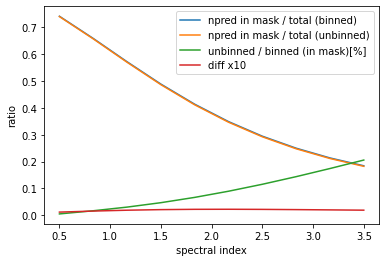

In [94]:
# with mask_safe.geom for the model
plt.plot(alphas, ratio_binned, label='npred in mask / total (binned)')
plt.plot(alphas, ratio_unbinned, label='npred in mask / total (unbinned)')
plt.plot(alphas, (np.array(ratio_both)-1)*1000, label='unbinned / binned (in mask)[%]')
plt.plot(alphas, (np.array(ratio_binned)-ratio_unbinned)*10, label='diff x10')
plt.legend()
plt.ylabel('ratio')
plt.xlabel('spectral index')

Text(0.5, 0, 'spectral index')

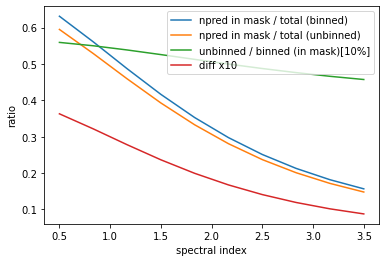

In [43]:
# with geom_model
plt.plot(alphas, ratio_binned, label='npred in mask / total (binned)')
plt.plot(alphas, ratio_unbinned, label='npred in mask / total (unbinned)')
plt.plot(alphas, (np.array(ratio_both)-1)*-10, label='unbinned / binned (in mask)[10%]')
plt.plot(alphas, (np.array(ratio_binned)-ratio_unbinned)*10, label='diff x10')
plt.legend()
plt.ylabel('ratio')
plt.xlabel('spectral index')

# Conclusion
We see nearly perfect agreement (<0.4%) if the model_geometry is the same as the mask_safe geometry. Otherwise the acceptance gives ~ 6% less of the counts compared to the application of mask_safe.

We improve a little to 5.5% when using the same energy axis.
A similar amount when choosing the same pixels and also when both are equal

We improve up to 3% when the geometries are alligned, i.e. also using obs_pos as center and the same pixel size

TODO: Check if Edisp is the reason for bad performance with different energy axes by enabling and disabling the edisp  
    -> the edisp has only a very minor influence on the difference
 
But the psf has a large influence. By disabling the psf we get almost perfect agreement.  
Also if the source in not near the mask's edge the influence of the PSF is small.  
The exact position of the interpolation of the `PSFMap` to the `PSFKernel` seems to have a rather large influence on the exact values of the kernel.